In [26]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
import os
import graphviz
import matplotlib.pyplot as plt
import timeit

In [2]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
#DATA_PATH = "~chandlermccann/Downloads/"
DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [4]:
df= pd.read_csv(INPUT_FILE, encoding='latin-1')
df.head()

,country_name,water_source,water_tech,status_id,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,time_since_measurement,time_since_meas_years,age_well_years,fuzzy_water_source,fuzzy_water_tech
0,"Tanzania, United Republic of",Spring,Gravity Communal standpipe,no,__MISSING__,Never pay,RWE,1972.0,Status:Not functional|Quantity:Dry|Quality:Soft,SNV,Arusha,Longido,wpdx-00000001,01/05/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.83257,36.3090,"(-2.83257, 36.309)",1,NaN,NaN,NaN,2008-01-05,1972-01-01 00:00:00,13153 days 00:00:00.000000000,13153,1,3710 days 00:00:00.000000000,10.2,36.0,Spring River Stream Protected,Gravity
1,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Breakdown Year:2007|Reason N...,SNV,Arusha,Longido,wpdx-00000002,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84781,36.5284,"(-2.84781, 36.5284)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3714 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
2,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000003,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84796,36.5288,"(-2.84796, 36.5288)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3714 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
3,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000004,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.85318,36.5276,"(-2.85318, 36.5276)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3714 days 00:00:00.000000000,10.2,3.0,Rain Rainwater,Gravity
4,Nicaragua,__MISSING__,__MISSING__,yes,__MISSING__,__MISSING__,__MISSING__,2011.0,__MISSING__,El Porvenier,Matagalpa,Terrabona,wpdx-00000005,01/01/2011 12:00:00 AM +0000,NI,__MISSING__,http://www.dropbox.com/s/0f70mln5roxhy29/ProjT...,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,"#data_lnk, #lon_deg, #lat_deg, #country_id",04/08/2016 08:35:49 AM +0000,04/08/2016 08:35:49 AM +0000,12.74070,-86.0121,"(12.7407, -86.0121)",1,NaN,NaN,NaN,2011-01-01,2011-01-01 00:00:00,0 days 00:00:00.000000000,0,0,2618 days 00:00:00.000000000,7.2,0.0,__MISSING__ Unknown,__MISSING__


In [5]:
countries_for_preds = ['Afghanistan', 'Sierra Leone', 'Swaziland', 'Zimbabwe', 'Kenya', 'Liberia', 'Malawi', 'South Sudan', 
'Uganda','India']

In [6]:
#create a dictionary to store all of the dataframes in for each country level model with the country name as the key
df_dict = {}
for name in df.country_name.unique():

    df_dict[name] = df[df.country_name== name]

In [7]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

In [25]:

start_time = timeit.default_timer()
# code you want to evaluate
elapsed = timeit.default_timer() - start_time
elapsed

4.312799956096569e-05

In [66]:
def predict_country(country_name, feats):
    """ARGS: country name (as a string), list of features 
       Returns: Best XGBoost model with early stopping, label encoded X, Y"""
    #TODO - probably makes sense to split in to 3 functions: Split data & label encode, inner + outer cv, plotting
    start_time = timeit.default_timer()

    if type(country_name) != str:
        country_name = str(country_name)
        
    #import feature list
    pred_cols = feats
    
    #create a copy of the dataframe to label encode
    df2 = df_dict[country_name].copy()
    df2=df2[pred_cols]

    X = df2[df2.columns[:-1]] 
    Y= df2.status_binary

    X2 = X.copy()

    #convert all fields to int labels for XGBoost
    lb=LabelEncoder() #instantiate label encoder

    #create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
    #from collections import defaultdict
    #d = defaultdict(LabelEncoder)

    #adding this line in order to NOT select lat/lon; other int columns for label encoding
    #TO DO - If we have new data coming in we need to invert it at some point
    cols = X2.select_dtypes(include=['object']).columns

    # Encoding each variable
    for col in cols:
        X2[col]= lb.fit_transform(X[col])
    #fit = df2.apply(lambda x: d[x.name].fit_transform(x)) 
    #Inverse the encoded
    #inverse = fit.apply(lambda x: d[x.name].inverse_transform(x))
    
    #split in to 80/20 train test
    #TO DO - use custom indices instead of train test split
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X2, Y,  test_size=.2, random_state=7, stratify=Y)
    
        ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
        #### in XGBoost Settings to generalize better

    # Set gridsearch
    print("beggining inner CV...")
    params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
    model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                            colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
    model_inner.fit(X_train, y_train )
    print('model fit for inner CV for', df2.country_name.unique())
    print('Shape of input params= ', X_train.shape)
    print('Best searched parameters on inner CV', model_inner.best_params_)
    print('Best grid score on inner CV', model_inner.best_score_)



    #get auc. 
    preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
    preds_inner_accuracy = model_inner.predict(X_test)
    print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
    print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))
    
    #store the best settings from our most recent, regularized XGBoost model above
    #perform early stopping
    print("beginning")
    model_outer = model_inner.best_estimator_
    xgb_param =model_outer.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    #start with 2500 trees and early stop 
    #use XGB cross-validation to determine our early stopping parameter
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
                metrics='auc', early_stopping_rounds=200)
    #set number of trees to where early stopping occurred
    model_outer.set_params(n_estimators=cvresult.shape[0])


    #Fit the algorithm on the data
    model_outer.fit(X_train, y_train,eval_metric='auc')

    #Predict training set:
    dtrain_predictions = model_outer.predict(X_train)
    dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
    dtest_predprob = model_outer.predict_proba(X_test)[:,1]

    #Print model report:
    print("\nModel Report")
    print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
    print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

        # method I: plt
   
    
#     #plot results
#     plt.figure(figsize=(14,4))
#     plt.title("Feature importance for outer_cv model: ", df2.country_name.unique())
#     xgb.plot_importance(model_outer)
    
#     #plot ROC curve
#     fpr, tpr, threshold = metrics.roc_curve(y_test, dtest_predprob)
#     roc_auc = metrics.auc(fpr, tpr)


#     plt.title('ROC Curve - Training')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    elapsed = timeit.default_timer() - start_time
    print("Total time(s): ",elapsed)
    return model_outer, X2, Y #best model, full label encoded X, target Y

In [30]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [44]:
def append_preds(country, preds, probs):
    results = df_dict[country].copy()
    results['cv_predictions']=preds
    results['cv_probabilities']=probs[:,1]
    
    print("Number of known bad wells (true negatives): ",results.status_binary.sum())
    print("Number of predicted bad wells: ", results.cv_predictions.sum())
    print("Number of predicted bad wells that are recorded as functional (false positives)", results.loc[(results.status_binary==0) & (results.cv_predictions==1)].shape[0])
    print("Number of predicted fucntional wells that are recorded as bad (false negatives)", results.loc[(results.status_binary==1) & (results.cv_predictions==0)].shape[0])
    print("confusion matrix: \n", metrics.confusion_matrix(Y, preds))
    return results

In [29]:
start_time = timeit.default_timer()
sierra_model, X, Y = predict_country(df_dict['Sierra Leone'], features)
elapsed = timeit.default_timer() - start_time
elapsed
#should add some progress print statements and timing measures

model fit for inner CV for ['Sierra Leone']
Shape of input params=  (43891, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'n_estimators': 2500, 'max_depth': 5}
Best grid score on inner CV 0.935430953954
Accuracy for inner nested_cv model : 0.9345
AUC Score (test) for inner_nested cv_model: 0.968687

Model Report
Accuracy for outer nested_cv model on training data: 0.9477
AUC Score (Train) for outer nested_cv model: 0.984779
AUC Score (Test) for outer nested_cv model: 0.968058


1005.6379559139996

In [31]:
preds, probs = get_nested_cv_preds(sierra_model, X, Y)

full data AUC- CV score [ 0.97045668  0.96750603  0.97065527  0.97004205  0.96614581]
Accuracy full-data : 0.9365
AUC Score full-data: 0.968908


In [45]:
sierra_results = append_preds("Sierra Leone", preds, probs)

Number of known bad wells (true negatives):  12426
Number of predicted bad wells:  9967
Number of predicted bad wells that are recorded as functional (false positives) 512
Number of predicted fucntional wells that are recorded as bad (false negatives) 2971


In [49]:
print("confusion matrix: \n", metrics.confusion_matrix(Y, preds))

confusion matrix: 
 [[41926   512]
 [ 2971  9455]]


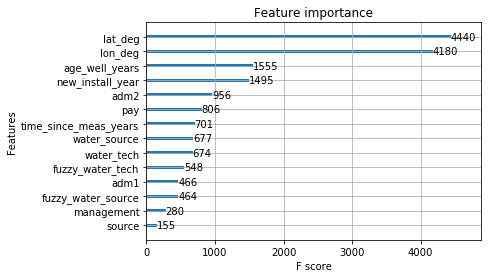

In [57]:
xgb.plot_importance(sierra_model)

In [ ]:
#these would be some useful summary graphs per country
#maybe show average life +/- per tech?
#have a summary page per country that allows them to explore the summary data more

#also begin creating a methodology page, and an outline for a summary page per country

In [32]:
gp = df_dict[ 'Sierra Leone'].groupby(['country_name','fuzzy_water_source','age_well_years','status_binary']).size().unstack()
gp['prop'] = gp[1] / gp.sum(axis=1)
gp.reset_index(inplace=True)
gp.rename(columns={0:'functioning', 1:'not functioning'}, inplace=True)
gp.sort_values(by='not functioning', ascending=False)

status_binary,country_name,fuzzy_water_source,age_well_years,functioning,not functioning,prop
949,Sierra Leone,Stand Post Tap,274.0,790.0,1194.0,0.601815
1460,Sierra Leone,Well,274.0,2036.0,1131.0,0.357120
1111,Sierra Leone,Well,9.1,894.0,148.0,0.142035
1066,Sierra Leone,Well,4.1,660.0,124.0,0.158163
145,Sierra Leone,Borehole,274.0,122.0,122.0,0.500000
1093,Sierra Leone,Well,7.1,454.0,120.0,0.209059
1084,Sierra Leone,Well,6.1,553.0,119.0,0.177083
1088,Sierra Leone,Well,6.6,315.0,116.0,0.269142
1057,Sierra Leone,Well,3.1,825.0,115.0,0.122340
1102,Sierra Leone,Well,8.1,465.0,110.0,0.191304


In [12]:
gp = df_dict[ 'Sierra Leone'].groupby(['country_name','fuzzy_water_tech','status_binary']).size().unstack()
gp['prop'] = gp[1] / gp.sum(axis=1)
gp.reset_index(inplace=True)
gp.rename(columns={0:'functioning', 1:'not functioning'}, inplace=True)
gp.sort_values(by='not functioning', ascending=False)

status_binary,country_name,fuzzy_water_tech,functioning,not functioning,prop
10,Sierra Leone,__MISSING__,8688.0,4416.0,0.336996
4,Sierra Leone,India Mark MK IMK II,12582.0,4235.0,0.251829
1,Sierra Leone,Bucket,13358.0,1051.0,0.072941
2,Sierra Leone,Gravity,2181.0,978.0,0.309592
5,Sierra Leone,Kardia,3237.0,710.0,0.179883
3,Sierra Leone,Hand Pump,801.0,418.0,0.342904
11,Sierra Leone,no match,691.0,317.0,0.314484
0,Sierra Leone,Afridev,707.0,198.0,0.218785
12,Sierra Leone,tap,177.0,76.0,0.300395
9,Sierra Leone,Well,1.0,19.0,0.950000


# Malawi

In [64]:
malawi_model, X2, Y2 = predict_country("Malawi", features)

beggining inner CV...
model fit for inner CV for ['Tanzania, United Republic of' 'Nicaragua' 'Afghanistan' 'Somalia'
 'Malawi' 'Zambia' 'Ghana' 'Mali' 'Niger' 'Rwanda' 'Uganda' 'Kenya'
 'Ethiopia' 'Mozambique' 'Sierra Leone' 'Liberia' 'Guatemala' 'Mexico'
 'Colombia' 'Honduras' 'Timor-Leste' 'South Sudan' 'India'
 'Bolivia, Plurinational State of' 'Peru' 'Nigeria' "CÃ\x83Â´te d'Ivoire"
 'Burkina Faso' 'Congo, The Democratic Republic of the' 'Gambia' 'Namibia'
 'El Salvador' 'Zimbabwe' 'Haiti' 'Central African Republic' 'Swaziland'
 'Madagascar' 'Bangladesh' 'Sri Lanka' 'Indonesia' 'Dominican Republic'
 'Philippines' 'Nepal' 'Puerto Rico' 'Sint Maarten (Dutch part)' 'Cambodia'
 'Myanmar' 'Burundi' 'Belize']
Shape of input params=  (9808, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 7}
Best grid score on inner CV 0.832177814029
Accuracy for inner nested_cv model : 0.8393
AUC Score (test) for inner_nested cv_model: 0.846091
beginning


In [67]:
preds2, probs2 = get_nested_cv_preds(malawi_model, X2, Y2)

full data AUC- CV score [ 0.8501684   0.84188386  0.84264464  0.86680785  0.85055654]
Accuracy full-data : 0.8356
AUC Score full-data: 0.850279


In [68]:
malawi_results = append_preds("Malawi", preds2, probs2)

Number of known bad wells (true negatives):  3075
Number of predicted bad wells:  2015
Number of predicted bad wells that are recorded as functional (false positives) 478
Number of predicted fucntional wells that are recorded as bad (false negatives) 1538


In [73]:
for k in countries_for_preds:
    print(k,df_dict[k].shape)

Afghanistan (59849, 35)
Sierra Leone (54864, 35)
Zimbabwe (38777, 35)
Tanzania, United Republic of (23462, 35)
Kenya (21207, 35)
Liberia (14053, 35)
Malawi (12260, 35)
South Sudan (6088, 35)
Uganda (113667, 35)
India (5887, 35)


# To Do
    - Neatly show what is missing between which countries - Done
    - Grid search another classifier like random forests in addition to XGBoost.
    - Convert Uganda pay to currency using regex
    - use fuzzy wuzzy to organize water source and tech - sort of done.  WILL BE IMPORTANT FOR SURVIVAL ANALYSIS.
    - run country level models on each main country - DONE
    - Time since last measurement as new variable
    - clean function to fill in missing on certain values and then handline missing age_well differently - DONE
    - create a dict of label encodings so I can transform back!! SUPER IMPORTANT - DONE
    - Analyze rows that have multiple data points for time series work and remove
    - Globally, "None" is a value and isn't "Missing", need to merge all of thme (list below)
    -***Show AUC curve for Swaziland, Uganda**** -DONE
    -***Show Feature impact for Swaziland, Uganda***- DONE
    -****Show Partial Dependence Plots for Swaziland, Uganda*** - Have label encoding. Can now.
    -***Recalculate Uganda with Fuzzy Matched Columns****--DONE for tech, not source in Fuzzy notebook
    -*** use map func page 194 to replace all the weird nulls
    - create bins for age well in 5 year increments
    -map: water tech (India, Mark, mk,II--> India Mark2), (Bush Pump--> a,b,c- well labeled, keep), (Null, 0, None Other, no pump--> __Missing__), (Afridev has many associations), (gravity, gravity fed---> gravity), (brands--> Kabul, birka, india, afridev, nira), Stand, Tap, Bucket, 
    - map: water source (Dam river stream, borehole, dug well, tube well, shallowe well, well, 
    - addres missing values (multiple per) in Water Tech, Water Source, then do fuzzy match
    
    Contains ‘rain’ - 15,417
"""Contains ‘gravity’ - 17,022
Contains  ‘bore’ - 32,182
Contains ‘dug_well’ = 22,616
‘Shallow well’ = 17, 361
Tube well = 6368
Spring = 25,871
null/0ther = 60,000
Stand: 43, 531
Bucket: 27k
Tap: 6.7k """




    